In [2]:
!pip install scikit-learn

In [3]:
!pip install keras
!pip install --upgrade tensorflow

In [4]:
import pandas as pd
import os
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.optimizers import Adam

C:\Users\jason\AppData\Local\Temp\ipykernel_35104\1286902208.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [5]:
file_paths = [ '../gradebook_data/1.csv' , '../gradebook_data/2.csv', '../gradebook_data/3.csv' , '../gradebook_data/4.csv' ]
gradebooks = [pd.read_csv(file) for file in file_paths]
gradebook_previews = [df.head() for df in gradebooks]
gradebooks

[                 Student         ID  SIS User ID  \
 0                    NaN        NaN          NaN   
 1        Points Possible        NaN          NaN   
 2                      1        NaN          NaN   
 3                      2        NaN          NaN   
 4                      3        NaN          NaN   
 ..                   ...        ...          ...   
 119                  118        NaN          NaN   
 120                  119        NaN          NaN   
 121                  120        NaN          NaN   
 122                  121        NaN          NaN   
 123        Student, Test  4417610.0          NaN   
 
                                  SIS Login ID        Root Account  \
 0                                         NaN                 NaN   
 1                                         NaN                 NaN   
 2                                         NaN  webcourses.ucf.edu   
 3                                         NaN  webcourses.ucf.edu   
 4          

In [6]:
# Applying the preprocessing steps to all datasets
cleaned_gradebooks = []

for df in gradebooks:
    # Dropping rows and columns that are not relevant or are placeholders
    df_cleaned = df.drop(index=[0, 1])  # Drop the first two rows which are placeholders
    df_cleaned = df_cleaned.drop(columns=["ID", "SIS User ID", "SIS Login ID", "Root Account", "Section"])  # Drop identifier columns

    # Handling missing values - Assuming that missing values in grades can be treated as zeros
    df_cleaned = df_cleaned.fillna(0)

    # Convert grades to numeric where possible
    for col in df_cleaned.columns[1:]:  # Skipping the first column which is the student name
        df_cleaned[col] = pd.to_numeric(df_cleaned[col], errors='coerce').fillna(0)
    
    cleaned_gradebooks.append(df_cleaned)

# Displaying the first few rows of each cleaned dataset
cleaned_gradebook_previews = [df.head() for df in cleaned_gradebooks]
cleaned_gradebook_previews

C:\Users\jason\AppData\Local\Temp\ipykernel_35104\4256943613.py:10: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_cleaned = df_cleaned.fillna(0)
C:\Users\jason\AppData\Local\Temp\ipykernel_35104\4256943613.py:10: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_cleaned = df_cleaned.fillna(0)
C:\Users\jason\AppData\Local\Temp\ipykernel_35104\4256943613.py:10: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future 

[  Student  \
 2       1   
 3       2   
 4       3   
 5       4   
 6       5   
 
    Student's Request for Authorization of Absence - Webcourses Quiz for Step 1 (7914767)  \
 2                                                  0                                       
 3                                                  0                                       
 4                                                  0                                       
 5                                                  0                                       
 6                                                  0                                       
 
    Attendance - Final Exam Rebuttal 67% or more (7914860)  \
 2                                              95.56        
 3                                              90.00        
 4                                              83.33        
 5                                              90.56        
 6                                          

In [7]:
# Concatenate the cleaned datasets
concatenated_df = pd.concat(cleaned_gradebooks, ignore_index=True)

# Display the shape of the concatenated dataset and the first few rows
concatenated_df_shape = concatenated_df.shape
concatenated_df_head = concatenated_df.head()

concatenated_df_shape, concatenated_df_head


((389, 229),
   Student  \
 0       1   
 1       2   
 2       3   
 3       4   
 4       5   
 
    Student's Request for Authorization of Absence - Webcourses Quiz for Step 1 (7914767)  \
 0                                                0.0                                       
 1                                                0.0                                       
 2                                                0.0                                       
 3                                                0.0                                       
 4                                                0.0                                       
 
    Attendance - Final Exam Rebuttal 67% or more (7914860)  \
 0                                              95.56        
 1                                              90.00        
 2                                              83.33        
 3                                              90.56        
 4                             

In [8]:
# Identifying the column for the final score (assuming the last few columns are summary columns)
final_score_column = 'Final Score' if 'Final Score' in concatenated_df.columns else concatenated_df.columns[-3]
concatenated_df['At_Risk'] = concatenated_df[final_score_column] < 60  # 'At_Risk' is True if Final Score is less than 60
concatenated_df = concatenated_df.copy()
# Preparing data for LSTM
# We'll drop columns that are not relevant for LSTM (like final scores, grades, and student identifiers)
lstm_features = concatenated_df.drop(columns=[final_score_column, 'Current Score', 'Unposted Current Score', 
                                              'Unposted Final Score', 'Current Grade', 'Unposted Current Grade', 
                                              'Final Grade', 'Unposted Final Grade', 'Student'])

# For LSTM, we need to ensure all sequences (rows) are of the same length
# We'll pad shorter sequences with zeros
max_sequence_length = lstm_features.shape[1]
lstm_features = lstm_features.to_numpy()

# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(lstm_features, concatenated_df['At_Risk'], test_size=0.2, random_state=42)

# Displaying the shapes of the training and testing sets
X_train.shape, X_test.shape, y_train.shape, y_test.shape

C:\Users\jason\AppData\Local\Temp\ipykernel_35104\2847268638.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  concatenated_df['At_Risk'] = concatenated_df[final_score_column] < 60  # 'At_Risk' is True if Final Score is less than 60


((311, 221), (78, 221), (311,), (78,))

In [9]:
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(25))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

In [10]:
X_train_reshaped = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test_reshaped = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
X_test_reshaped.shape

(78, 221, 1)

In [13]:
X_test_reshaped = X_test_reshaped.astype('float32')

In [14]:
# Making predictions
predictions = model.predict(X_test_reshaped)
predicted_labels = (predictions > 0.5).astype(int)  # Convert probabilities to binary labels


3/3 [==============================] - 2s 63ms/step


In [19]:
predicted_labels

array([[0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0]])

In [16]:
!pip install seaborn

   ---------------------------------------- 0.0/294.9 kB ? eta -:--:--
   ---- ---------------------------------- 30.7/294.9 kB 660.6 kB/s eta 0:00:01
   -------------------- ------------------- 153.6/294.9 kB 1.8 MB/s eta 0:00:01
   ---------------------------------------- 294.9/294.9 kB 2.6 MB/s eta 0:00:00


In [17]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

C:\Users\jason\miniconda\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Accuracy: 0.9487179487179487
Precision: 0.0
Recall: 0.0
F1 Score: 0.0


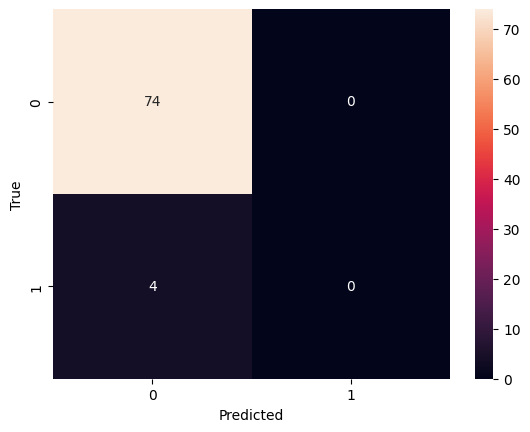

In [18]:
# Convert y_test to binary if it's not already
y_test_binary = y_test.astype(int)

# Calculate metrics
accuracy = accuracy_score(y_test_binary, predicted_labels)
precision = precision_score(y_test_binary, predicted_labels)
recall = recall_score(y_test_binary, predicted_labels)
f1 = f1_score(y_test_binary, predicted_labels)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

# Confusion Matrix
cm = confusion_matrix(y_test_binary, predicted_labels)
sns.heatmap(cm, annot=True, fmt="d")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()